<a href="https://colab.research.google.com/github/nguyen-brat/Devide-Subject-and-predicate/blob/main/T%C3%A1ch_c%E1%BB%A5m_ch%E1%BB%A7_v%E1%BB%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Start

In [ ]:
!pip install phonlp
!pip install py_vncorenlp


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import py_vncorenlp
import os
file_root = "/content/vncorenlp"
if not os.path.exists(file_root):
  os.makedirs(file_root, exist_ok=True)

py_vncorenlp.download_model(save_dir='/content/vncorenlp')

# Load VnCoreNLP for word and sentence segmentation
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/content/vncorenlp')

In [ ]:
print(rdrsegmenter.word_segment("Tôi đang làm việc tại đại học Bách Khoa Hồ Chí Minh, và chị tôi đang học tại đại học y tế cộng đồng"))

['Tôi đang làm_việc tại đại_học Bách_Khoa Hồ_Chí_Minh , và chị tôi đang học tại đại_học y_tế cộng_đồng']


In [ ]:
def word_segment(text):
    return rdrsegmenter.word_segment(text)[0]

In [ ]:
import phonlp

phonlp.download(save_dir='/content/phonlp_pretrained')

# Load the trained PhoNLP model
model = phonlp.load(save_dir='/content/phonlp_pretrained')

Downloading...
From: https://public.vinai.io/phonlp.pt
To: /content/phonlp_pretrained/phonlp.pt
100%|██████████| 582M/582M [00:03<00:00, 193MB/s]


Loading model from: /content/phonlp_pretrained/phonlp.pt


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
print(word_segment("Tôi đang làm việc tại đại học bách khoa hồ chí minh ."))
model.print_out(model.annotate(text=word_segment("Tôi đang làm việc tại đại học Bách Khoa Hồ Chí Minh .")))

In [ ]:
from typing import List

class Word:
    def __init__(self, form: str, index: int, posTag: str, nerLabel: str, depLabel: str, head=None, parent=None, children=None):
        self.text = form
        self.pos_tag = posTag
        self.index = index
        self.head = head
        self.parent = parent
        self.ner_label = nerLabel
        self.dep_label = depLabel
        self.children = children if children is not None else []

    @property
    def all_children(self):
        if len(self.children) > 0:
            output = [child for child in self.children]
            output.append(self)
            for child in self.children:
                output += child.all_children
            output = list(set(output))
            output.sort(key=lambda item: item.index)
            return output
        else:
            return [self]

    @property
    def is_noun(self):
        return self.pos_tag.startswith("N")

    @property
    def is_verb(self):
        return self.pos_tag.startswith("V")



class Sentence:
    def __init__(self, words: List[Word]):
        self.words = words
        self.root = None
        self._phrases = None
        self.build_tree()
        self.build_phrase_tree()
    
    def build_tree(self):
        word_dict = {word.index: word for word in self.words}
        for word in self.words:
            if word.head == 0:
                self.root = word
            else:
                parent = word_dict[word.head]
                word.parent = parent
                parent.children.append(word)

    def build_phrase_tree(self):
        phrase_dict = {phrase.root.index: phrase for phrase in self.phrases}
        for phrase in self.phrases:
            for other_phrase in self.phrases:
                if phrase.contains(other_phrase):
                    phrase.children.append(other_phrase)
                    if other_phrase.parent is None:
                        other_phrase.parent = phrase
                    elif other_phrase.parent.contains(phrase):
                        other_phrase.parent.children.remove(other_phrase)
                        other_phrase.parent = phrase
            if len(phrase.children) > 0:
                phrase.children.sort(key=lambda item: item.root.index)

    @property
    def text(self):
        return " ".join([word.text for word in self.words])
    
    @property
    def phrases(self):
        if self._phrases is None:
            output = []
            for word in self.words:
                output.append(Phrase(word.all_children, word))
            self._phrases = output
        return self._phrases

    @property
    def noun_phrases(self):
        return [phrase for phrase in self.phrases if phrase.is_noun_phrase]
    
    @property
    def verb_phrases(self):
        return [phrase for phrase in self.phrases if phrase.is_verd_phrase]

    def __str__(self):
        return self.text


class Phrase(Sentence):
    def __init__(self, words: List[Word], root: Word):
        super(Phrase, self).__init__(words)
        self.words = words
        self.root = root
        self.children = []
        self.parent = None
    
    def contains(self, other):
        if isinstance(other, Phrase):
            return other.root != self.root and other.root in self.words
        elif isinstance(other, Word):
            return other in self.words
        return False 
        
    def build_tree(self):
        pass

    def build_phrase_tree(self):
        pass
    
    @property
    def is_noun_phrase(self):
        return self.root.is_noun
    
    @property
    def is_verd_phrase(self):
        return self.root.is_verb

    @property
    def pos_tag(self):
        return self.root.pos_tag

    @property
    def dep_label(self):
        return self.root.dep_label

    @property
    def subject_phrase(self):
        phrases = [p for p in self.children if p.dep_label == "sub"]
        if len(phrases) > 0:
            return phrases[0]
        elif len(self.children) == 2:
            return self.children[0]
        return None 
    
    @property
    def object_phrase(self):
        phrases = [p for p in self.children if p.dep_label == "dob"]
        if len(phrases) > 0:
            return phrases[0]
        elif len(self.children) == 2:
            return self.children[-1]
        return None 


Annotator Class

In [ ]:
# class Annotator:
#     def __init__(self):
#         self.model = phonlp.load(save_dir='/content/phonlp_pretrained')
    
#     '''@staticmethod'''
#     def word_segment(text):
#         return rdrsegmenter.word_segment(text)[0]

#     def __call__(self, text):
#         words, postags, nertags, deptags = self.model.annotate(text=word_segment(text))
#         words = words[0]
#         postags = postags[0]
#         nertags = nertags[0]
#         deptags = deptags[0]
#         word_output = []
#         for i, (word, pos, ner, dep) in enumerate(zip(words, postags, nertags, deptags)):
#             word_output.append(Word(form=word, index=i+1, posTag=pos[0], nerLabel=ner[0], depLabel=dep[-1], head=int(dep[0]), parent=None, children=None))
#         sentence = Sentence(word_output)
#         return sentence

In [ ]:
##############
# vui ve
#############
class Annotator:
    def __init__(self):
        self.model = phonlp.load(save_dir='/content/phonlp_pretrained')

    def __call__(self, text):
        list_sen = []
        for txt in rdrsegmenter.word_segment(text):
          words, postags, nertags, deptags = self.model.annotate(text= txt)
          words = words[0]
          postags = postags[0]
          nertags = nertags[0]
          deptags = deptags[0]
          word_output = []
          for i, (word, pos, ner, dep) in enumerate(zip(words, postags, nertags, deptags)):
              word_output.append(Word(form=word, index=i+1, posTag=pos[0], nerLabel=ner[0], depLabel=dep[-1], head=int(dep[0]), parent=None, children=None))
          sentence = Sentence(word_output)
          list_sen.append(sentence)
        return list_sen

In [ ]:
!wget https://raw.githubusercontent.com/PhamNguyen97/BARTViBa/main/data/all/train.vi -O /content/train.text
!wget https://raw.githubusercontent.com/PhamNguyen97/BARTViBa/main/data/all/valid.vi -O /content/valid.text
!wget https://raw.githubusercontent.com/PhamNguyen97/BARTViBa/main/data/all/test.vi -O /content/test.text

In [ ]:
parser = Annotator()

Loading model from: /content/phonlp_pretrained/phonlp.pt


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
sentences = parser("Cách mạng tháng tám thành công đã mở ra bước ngoặc lớn. Nó đã mở sự tự do cho dân tộc")
#print(sentences)
# for phrase in sentence.phrases:
#     print(phrase.text, ">>>",phrase.root.text, ">>>", phrase.root.pos_tag,">>>" , [p.text for p in phrase.children])

# for phrase in sentence.verb_phrases:
#     print("________", phrase.root.text)
#     print("POSTAG", phrase.pos_tag)
#     print("TEXT", phrase.text)
#     print("SUBJECT", phrase.subject_phrase)
#     print("OBJECT", phrase.object_phrase)

100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


In [ ]:
# https://github.com/NTT123/viwik18/tree/viwik19/dataset

## Bắt đầu làm

In [ ]:
word_before_predicate = ['vừa', 'đã', 'đang', 'sẽ','sắp', 'mới', 'chỉ', 'cũng', 'thì', 'mà', 'là', 'không' ,'chẳng' ,'chả', 'có' ,'chưa',
                        'vẫn', 'đều', 'lại', 'cứ' ,'chỉ', 'đừng' ,'chớ' ,'hãy' ,'phải' ,'cần', 'nên', 'rất' ,'hơi' ,'quá', 'thường',
                        'hay', 'năng', 'ít', 'hiếm', 'ít khi', 'thỉnh thoảng', 'luôn', 'luôn luôn']

In [ ]:
######################
# vui vẻ là chính
#####################
def help_count(sentence: str)->int:
  list_sub_predicate = []
  num_subj = 0
  dictionary = {}
  num_verb = 0
  if (len(sentence) == 0):
    return 0, {0:1}, 1, []
  sentences = parser(sentence)
  for sentence in sentences:
    num_sub = 0
    for word in sentence.words:
        if word.dep_label == 'sub':
          num_sub += 1
        if word.pos_tag == 'V':
          num_verb += 1
    if num_sub > 0:
      if 1 in list(dictionary.keys()):
        dictionary[1] += 1
      else:
        dictionary[1] = 1
      num_sub = 0
      # for word in sentence.root.children:
      #   print(word.text, word.pos_tag)
      # cấu trúc câu tổng quát lúc này là S + V + Predicate(nếu có) + (từ nối/,)(nếu có) + mệnh đề 2 (nếu có) +...+ mệnh đề n (nếu có)
      list_boundary = []
      for child in sentence.root.children:
        child_label = child.dep_label
        if (child_label == 'punct') | (child_label == 'coord'):
          list_boundary.append(child.index)
      list_boundary = [i for i in list_boundary]
      boundary = len(sentence.words) + 1
      list_boundary.sort()
      if len(list_boundary)>0:
        boundary = list_boundary[0]
      # print(f'list boundary: {list_boundary}')

      # nếu trong mệnh đề đầu tiên nếu có chủ ngữ thì num_sub + 1
      sen = []
      list_sub = []
      add = 0
      for word in sentence.words[:boundary - 1]:
        sen.append(word.text.replace('_', ' '))
        if word.dep_label == 'sub':
          list_sub.append(word.index)
          add += 1
      first_clause = ' '.join(sen)
      # nếu câu không có thành phần ghép đẳng lập
      if (add > 0) & (len(list_boundary) == 0):
        if list_sub[0] < sentence.root.index:
          num_sub += 1
          previous_word = sentence.words[sentence.root.index - 2]
          if previous_word.text.replace('_', ' ') in word_before_predicate:
            predicate_list = sentence.words[sentence.root.index - 2 : boundary - 1]
            sub_list = sentence.words[:sentence.root.index - 2]
          else:
            predicate_list = sentence.words[sentence.root.index - 1: boundary - 1]
            sub_list = sentence.words[:sentence.root.index - 1]
          list_sub_predicate.append(['Mệnh đề chính là: ' + ' '.join(sen) + ' || chủ ngữ là: ' + ' '.join([word.text.replace('_', ' ') for word in sub_list]) +
                  ' || vị ngữ là: ' + ' '.join([word.text.replace('_', ' ')  for word in predicate_list])])
          ## find extra clause in sub
          sub_start = 0
          for i, word in enumerate(sub_list):
            if (word.pos_tag == 'N') | (word.pos_tag == 'Np'):
              sub_start = i
              break;
          pre_start = 0
          for i, word in enumerate(predicate_list):
            if (word.pos_tag == 'N') | (word.pos_tag == 'Np'):
              pre_start = i
              break
          extra_clause_sub_list = sub_list[sub_start:]
          extra_clause_sub = ' '.join([word.text.replace('_', ' ') for word in extra_clause_sub_list])
          extra_clause_pre_list = predicate_list[pre_start:]
          extra_clause_pre = ' '.join([word.text.replace('_', ' ') for word in extra_clause_pre_list])
          #print(extra_clause_sub) ################
          result, dic, _, clause = help_count(extra_clause_sub)
          list_sub_predicate += clause
          num_sub += result
          for key in dic:
            if key != 0:
              if (key+1) in dictionary:
                dictionary[key+1] += dic[key]
              else:
                dictionary[key+1] = dic[key]
          #print(extra_clause_pre) ################
          result, dic, _, clause = help_count(extra_clause_pre)
          list_sub_predicate += clause
          num_sub += result
          for key in dic:
            if key != 0:
              if (key+1) in dictionary:
                dictionary[key+1] += dic[key]
              else:
                dictionary[key+1] = dic[key]
        ## root index is 1
        else:
          first_sub = list_sub[0]
          sub_sentence = ' '.join([word.text.replace('_', ' ') for word in sentence.words[first_sub-1:boundary - 1]])
          #print(sub_sentence) ###############
          result, dic, _, clause = help_count(sub_sentence)
          list_sub_predicate += clause
          num_sub += result
          for key in dic:
            if key != 0:
              if (key+1) in dictionary:
                dictionary[key+1] += dic[key]
              else:
                dictionary[key+1] = dic[key]
      # nếu câu không là câu đơn thì đề quy lại mệnh đề thứ nhất
      else:
        result, dic, _, clause = help_count(first_clause)
        list_sub_predicate += clause
        num_sub += result
        for key in dic:
          if key != 0:
            if (key+1) in dictionary:
              dictionary[key+1] += dic[key]
            else:
              dictionary[key+1] = dic[key]
      
      # nếu câu có từ nối hoặc dấu nối
      if len(list_boundary)>0:
        #print(f'boundary: {boundary}') ######################
        # nếu câu là câu ghép cộng đệ quy những mệnh đề lại bằng hàm help_count
        for i, bound in enumerate(list_boundary[:-1]):
          if list_boundary[i] + 1 != list_boundary[i+1]:
            start_idx = bound
            end_idx = list_boundary[i+1] - 1
            list_word_sentence = [word.text.replace('_', ' ') for word in sentence.words[start_idx: end_idx]]
            string = ' '.join(list_word_sentence)
            #print(string) ##################
            #print(f'mệnh đề khác: {string}') ################################
            result, dic, _, clause = help_count(string)
            list_sub_predicate += clause
            num_sub += result
            for key in dic:
              if key != 0:
                if (key+1) in dictionary:
                  dictionary[key+1] += dic[key]
                else:
                  dictionary[key+1] = dic[key]

        if list_boundary[-1] < sentence.words[-1].index - 1:
          start_idx = list_boundary[-1]
          list_word_sentence = [word.text.replace('_', ' ') for word in sentence.words[start_idx:]]
          string = ' '.join(list_word_sentence)
          #print(f'mệnh đề khác: {string}') #####################################
          result, dic, _, clause = help_count(string)
          list_sub_predicate += clause
          num_sub += result
          for key in dic:
            if key != 0:
              if (key+1) in dictionary:
                dictionary[key+1] += dic[key]
              else:
                dictionary[key+1] = dic[key]

    num_subj += num_sub
  if num_subj == 0:
    return 0, {0:1}, num_verb, []
  else:
    return num_subj, dictionary, num_verb, list_sub_predicate

In [ ]:
def help_count(sentence: str)->int:
  list_sub_predicate = []
  num_subj = 0
  dictionary = {}
  num_verb = 0
  if (len(sentence) == 0):
    return 0, {0:1}, 1, []
  sentences = parser(sentence)
  for sentence in sentences:
    num_sub = 0
    for word in sentence.words:
        if word.dep_label == 'sub':
          num_sub += 1
        if word.pos_tag == 'V':
          num_verb += 1
    if num_sub > 0:
      num_sub = 0
      # cấu trúc câu tổng quát lúc này là S + V + Predicate(nếu có) + (từ nối/,)(nếu có) + mệnh đề 2 (nếu có) +...+ mệnh đề n (nếu có)
      list_boundary = []
      for child in sentence.root.children:
        child_label = child.dep_label
        if (child_label == 'punct') | (child_label == 'coord'):
          list_boundary.append(child.index)
      list_boundary = [i for i in list_boundary]
      boundary = len(sentence.words) + 1
      list_boundary.sort()
      if len(list_boundary)>0:
        boundary = list_boundary[0]
      # print(f'list boundary: {list_boundary}')

      # nếu trong mệnh đề đầu tiên nếu có chủ ngữ thì num_sub + 1
      sen = []
      list_sub = []
      add = 0
      for word in sentence.words[:boundary - 1]:
        sen.append(word.text.replace('_', ' '))
        if word.dep_label == 'sub':
          list_sub.append(word.index)
          add += 1
      first_clause = ' '.join(sen)

      # nếu câu không có thành phần ghép đẳng lập
      if (add > 0) & (len(list_boundary) == 0):
        # nếu câu có chủ ngữ nằm sau root chính (động từ hoặc tính từ) lúc này mô hình chạy đúng
        if list_sub[0] < sentence.root.index:
          # add to dictionary
          if 1 in list(dictionary.keys()):
            dictionary[1] += 1
          else:
            dictionary[1] = 1
          # add to num_sub
          num_sub += 1
          bound_sub_pre_index = sentence.root.index
          for child in sentence.root.children:
            if (child.text == 'là') & (sentence.root.text != 'là'):
              bound_sub_pre_index = child.index
              break # should we break ???? #############
          previous_word = sentence.words[bound_sub_pre_index - 2]
          if previous_word.text.replace('_', ' ') in word_before_predicate:
            predicate_list = sentence.words[bound_sub_pre_index - 2 : boundary - 1]
            sub_list = sentence.words[:bound_sub_pre_index - 2]
          else:
            predicate_list = sentence.words[bound_sub_pre_index - 1: boundary - 1]
            sub_list = sentence.words[:bound_sub_pre_index - 1]
          list_sub_predicate.append(['Mệnh đề chính là: ' + ' '.join(sen) + ' || chủ ngữ là: ' + ' '.join([word.text.replace('_', ' ') for word in sub_list]) +
                  ' || vị ngữ là: ' + ' '.join([word.text.replace('_', ' ')  for word in predicate_list])])
          ## find extra clause in sub
          sub_start = 0
          for i, word in enumerate(sub_list):
            if (word.pos_tag == 'N') | (word.pos_tag == 'Np') | (word.pos_tag == 'P'):
              sub_start = i
              break;
          pre_start = 0
          for i, word in enumerate(predicate_list):
            if (word.pos_tag == 'N') | (word.pos_tag == 'Np') | (word.pos_tag == 'P'):
              pre_start = i
              break
          extra_clause_sub_list = sub_list[sub_start:]
          extra_clause_sub = ' '.join([word.text.replace('_', ' ') for word in extra_clause_sub_list])
          extra_clause_pre_list = predicate_list[pre_start:]
          extra_clause_pre = ' '.join([word.text.replace('_', ' ') for word in extra_clause_pre_list])
          #print(extra_clause_sub) ################
          result, dic, _, clause = help_count(extra_clause_sub)
          list_sub_predicate += clause
          num_sub += result
          for key in dic:
            if key != 0:
              if (key+1) in dictionary:
                dictionary[key+1] += dic[key]
              else:
                dictionary[key+1] = dic[key]
          #print(extra_clause_pre) ################
          result, dic, _, clause = help_count(extra_clause_pre)
          list_sub_predicate += clause
          num_sub += result
          for key in dic:
            if key != 0:
              if (key+1) in dictionary:
                dictionary[key+1] += dic[key]
              else:
                dictionary[key+1] = dic[key]
        ## root nắm ở đầu câu thì duyệt để tìm chủ ngữ đầu trong câu sai đó đệ quy hàm lại cho cụm mới tìm được
        else:
          first_sub = list_sub[0]
          sub_sentence = ' '.join([word.text.replace('_', ' ') for word in sentence.words[first_sub-1:boundary - 1]])
          #print(sub_sentence) ###############
          result, dic, _, clause = help_count(sub_sentence)
          list_sub_predicate += clause
          num_sub += result
          for key in dic:
            if key != 0:
              if key in dictionary:
                dictionary[key] += dic[key]
              else:
                dictionary[key] = dic[key]
      # nếu câu không là câu đơn thì đề quy lại mệnh đề thứ nhất
      else:
        result, dic, _, clause = help_count(first_clause)
        list_sub_predicate += clause
        num_sub += result
        for key in dic:
          if key != 0:
            if key in dictionary:
              dictionary[key] += dic[key]
            else:
              dictionary[key] = dic[key]
      
      # nếu câu có từ nối hoặc dấu nối
      if len(list_boundary)>0:
        if len(list_sub) > 0:
          first_sub = sentence.words[list_sub[0] - 1].text.replace('_', ' ')
        else:
          first_sub = ''
        #print(f'boundary: {boundary}') ######################
        # nếu câu là câu ghép cộng đệ quy những mệnh đề lại bằng hàm help_count
        for i, bound in enumerate(list_boundary[:-1]):
          if list_boundary[i] + 1 != list_boundary[i+1]:
            start_idx = bound
            end_idx = list_boundary[i+1] - 1
            list_word_sentence = [word.text.replace('_', ' ') for word in sentence.words[start_idx: end_idx]]
            string = ' '.join(list_word_sentence)
            #print(f'mệnh đề khác: {string}') ################################
            result, dic, _, clause = help_count(string)
            ## nếu không tìm ra thì chủ ngữ có thể nằm trong câu trước đó
            if result == 0:
              result, dic, _, clause = help_count(first_sub + ' ' + string)
            else:
              # nếu tìm ra thì đổi first_sub thành chủ ngữ mởi trong câu
              for word in sentence.words[start_idx: end_idx]:
                if word.dep_label == 'sub':
                  first_sub = word.text
                  break
            list_sub_predicate += clause
            num_sub += result
            for key in dic:
              if key != 0:
                if key in dictionary:
                  dictionary[key] += dic[key]
                else:
                  dictionary[key] = dic[key]

        if list_boundary[-1] < sentence.words[-1].index - 1:
          start_idx = list_boundary[-1]
          list_word_sentence = [word.text.replace('_', ' ') for word in sentence.words[start_idx:]]
          string = ' '.join(list_word_sentence)
          #print(f'mệnh đề khác: {string}') ####################
          result, dic, _, clause = help_count(string)
          if result == 0:
            result, dic, _, clause = help_count(first_sub + ' ' + string)
          list_sub_predicate += clause
          num_sub += result
          for key in dic:
            if key != 0:
              if key in dictionary:
                dictionary[key] += dic[key]
              else:
                dictionary[key] = dic[key]

    num_subj += num_sub
  if num_subj == 0:
    return 0, {0:1}, num_verb, []
  else:
    return num_subj, dictionary, num_verb, list_sub_predicate

In [ ]:
def count(file_paths):
  dictionary_degree = {}
  dictionary_pair = {}
  dictionary_verb = {}
  list_pair_in_lines = []
  # traversal throught folder
  for path in file_paths:
    with open(path, 'r') as f:
      data = f.readlines()
      for line in data:
        num_pair, dic, num_verb, list_sub_predicate = help_count(line)
        list_pair_in_lines.append(list_sub_predicate)
        ## add to degree dictionary
        for key in dic:
          if key not in list(dictionary_degree.keys()):
            dictionary_degree[key] = dic[key]
          else:
            dictionary_degree[key] += dic[key]
        # add to pair dictionary
        if num_pair not in list(dictionary_pair.keys()):
          dictionary_pair[num_pair] = 1
        else:
          dictionary_pair[num_pair] += 1
        # add to verb dictionary
        if num_verb not in list(dictionary_verb.keys()):
          dictionary_verb[num_verb] = 1
        else:
          dictionary_verb[num_verb] += 1

  return dictionary_verb, dictionary_pair, dictionary_degree, list_pair_in_lines

In [ ]:
os.chdir('/content')

In [ ]:
with open('/content/train.txt', 'r') as f:
  data1 = f.read()
with open('/content/train.txt', 'r') as f:
  data2 = f.read()
with open('/content/valid.txt', 'r') as f:
  data3 = f.read()

data = data1 + '\n' + data2 + '\n' + data3
with open('/content/data.txt', 'w') as f:
  f.write(data)

# Thử nghiệm

In [ ]:
model.print_out(model.annotate(text=word_segment("Bài viết Giang vừa soạn")))

100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

1	Bài	N	O	0	root
2	viết	V	O	1	nmod
3	Giang	Np	B-PER	5	sub
4	vừa	R	O	5	adv
5	soạn	V	O	1	nmod


In [ ]:
num_pair, dic_degree, num_verb, list_sub_predicate = help_count('Hắn cứ đi, cứ chửi, cứ dọa nạt, và cứ đi.')
print()
for pair in list_sub_predicate:
  print(pair)
print(f'the number of pair is {num_pair}')
print(f'the degree of the sentence if {dic_degree}')
print(f'the number of verb is {num_verb}')

100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


['Mệnh đề chính là: Hắn cứ đi || chủ ngữ là: Hắn || vị ngữ là: cứ đi']
['Mệnh đề chính là: Hắn cứ chửi || chủ ngữ là: Hắn || vị ngữ là: cứ chửi']
['Mệnh đề chính là: Hắn cứ doạ nạt || chủ ngữ là: Hắn || vị ngữ là: cứ doạ nạt']
['Mệnh đề chính là: Hắn cứ đi || chủ ngữ là: Hắn || vị ngữ là: cứ đi']
the number of pair is 4
the degree of the sentence if {1: 4}
the number of verb is 4


# XUẤT FILE

In [ ]:
verb_dic, sub_dic, degree_dic, list_pair_in_lines = count(['/content/data.txt'])

In [ ]:
import json
with open("CountVerbResult.json", "w") as f:
  json.dump(verb_dic, f)
with open("CounSubPrePair.json", "w") as f:
  json.dump(verb_dic, f)
with open("CountDegree.json", "w") as f:
  json.dump(verb_dic, f)

In [ ]:
with open('/content/data.txt', 'r') as f:
  data = f.readlines()

In [ ]:
for i, line in enumerate(data):
  path = os.path.join('/content/result', f'{i:05}.txt')
  with open(path, 'w') as f:
    f.write(line + '\n')
    f.write('-------------------------\n')
    for clause in list_pair_in_lines[i]:
      f.write(clause[0] + '\n')

In [ ]:
!zip -r result.zip /content/result

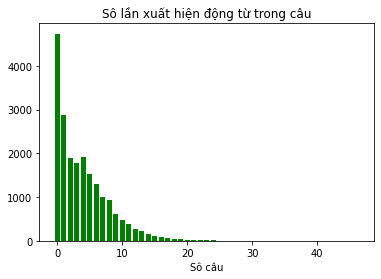

In [ ]:
import matplotlib.pyplot as plt
plt.bar(verb_dic.keys(), verb_dic.values(), color = 'g')
plt.title('Sô lần xuất hiện động từ trong câu')
plt.xlabel('Số lần xuất hiện động từ trong câu')
plt.xlabel('Sô câu')
plt.savefig('Đếm động từ')
plt.show()

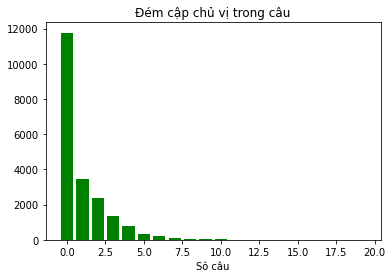

In [ ]:
plt.bar(sub_dic.keys(), sub_dic.values(), color = 'g')
plt.title('Đém cập chủ vị trong câu')
plt.xlabel('Số cặp chủ vị trong câu')
plt.xlabel('Sô câu')
plt.savefig('Đếm chủ vị')
plt.show()

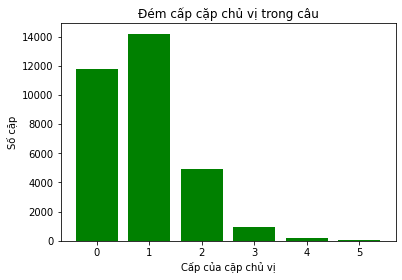

In [ ]:
plt.bar(degree_dic.keys(), degree_dic.values(), color = 'g')
plt.title('Đém cấp cặp chủ vị trong câu')
plt.xlabel('Cấp của cặp chủ vị')
plt.ylabel('Số cặp')
plt.savefig('Đếm cấp chủ vị')
plt.show()